In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
X = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Training_Patches_3D_SplitScript/Images/*.tif'))
Y = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Training_Patches_3D_SplitScript/Masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [ ]:
print(X)

In [ ]:
X, Y = X[:3], Y[:3]

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [5]:
Y_labels = []
for img in Y:
    array = np.array(img)
    array = (array * 255).astype(np.uint8)
    Y_labels.append(array)

In [5]:
extents = calculate_extents(Y_labels)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (16.0, 1.0, 1.0847457627118644)


In [12]:
i = 25
img, lbl = X[i], fill_label_holes(Y_labels[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)

In [13]:
plt.figure(figsize=(16,10))
z = img.shape[0] // 2
y = img.shape[1] // 2
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[:,y],cmap='gray');   plt.axis('off'); plt.title('Raw image (XZ slice)')
plt.subplot(122); plt.imshow(lbl[:,y],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XZ slice)')
None;

In [9]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y_labels]
        mean_iou = matching_dataset(Y_labels, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [10]:
n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [35:38<00:00, 356.35s/it]


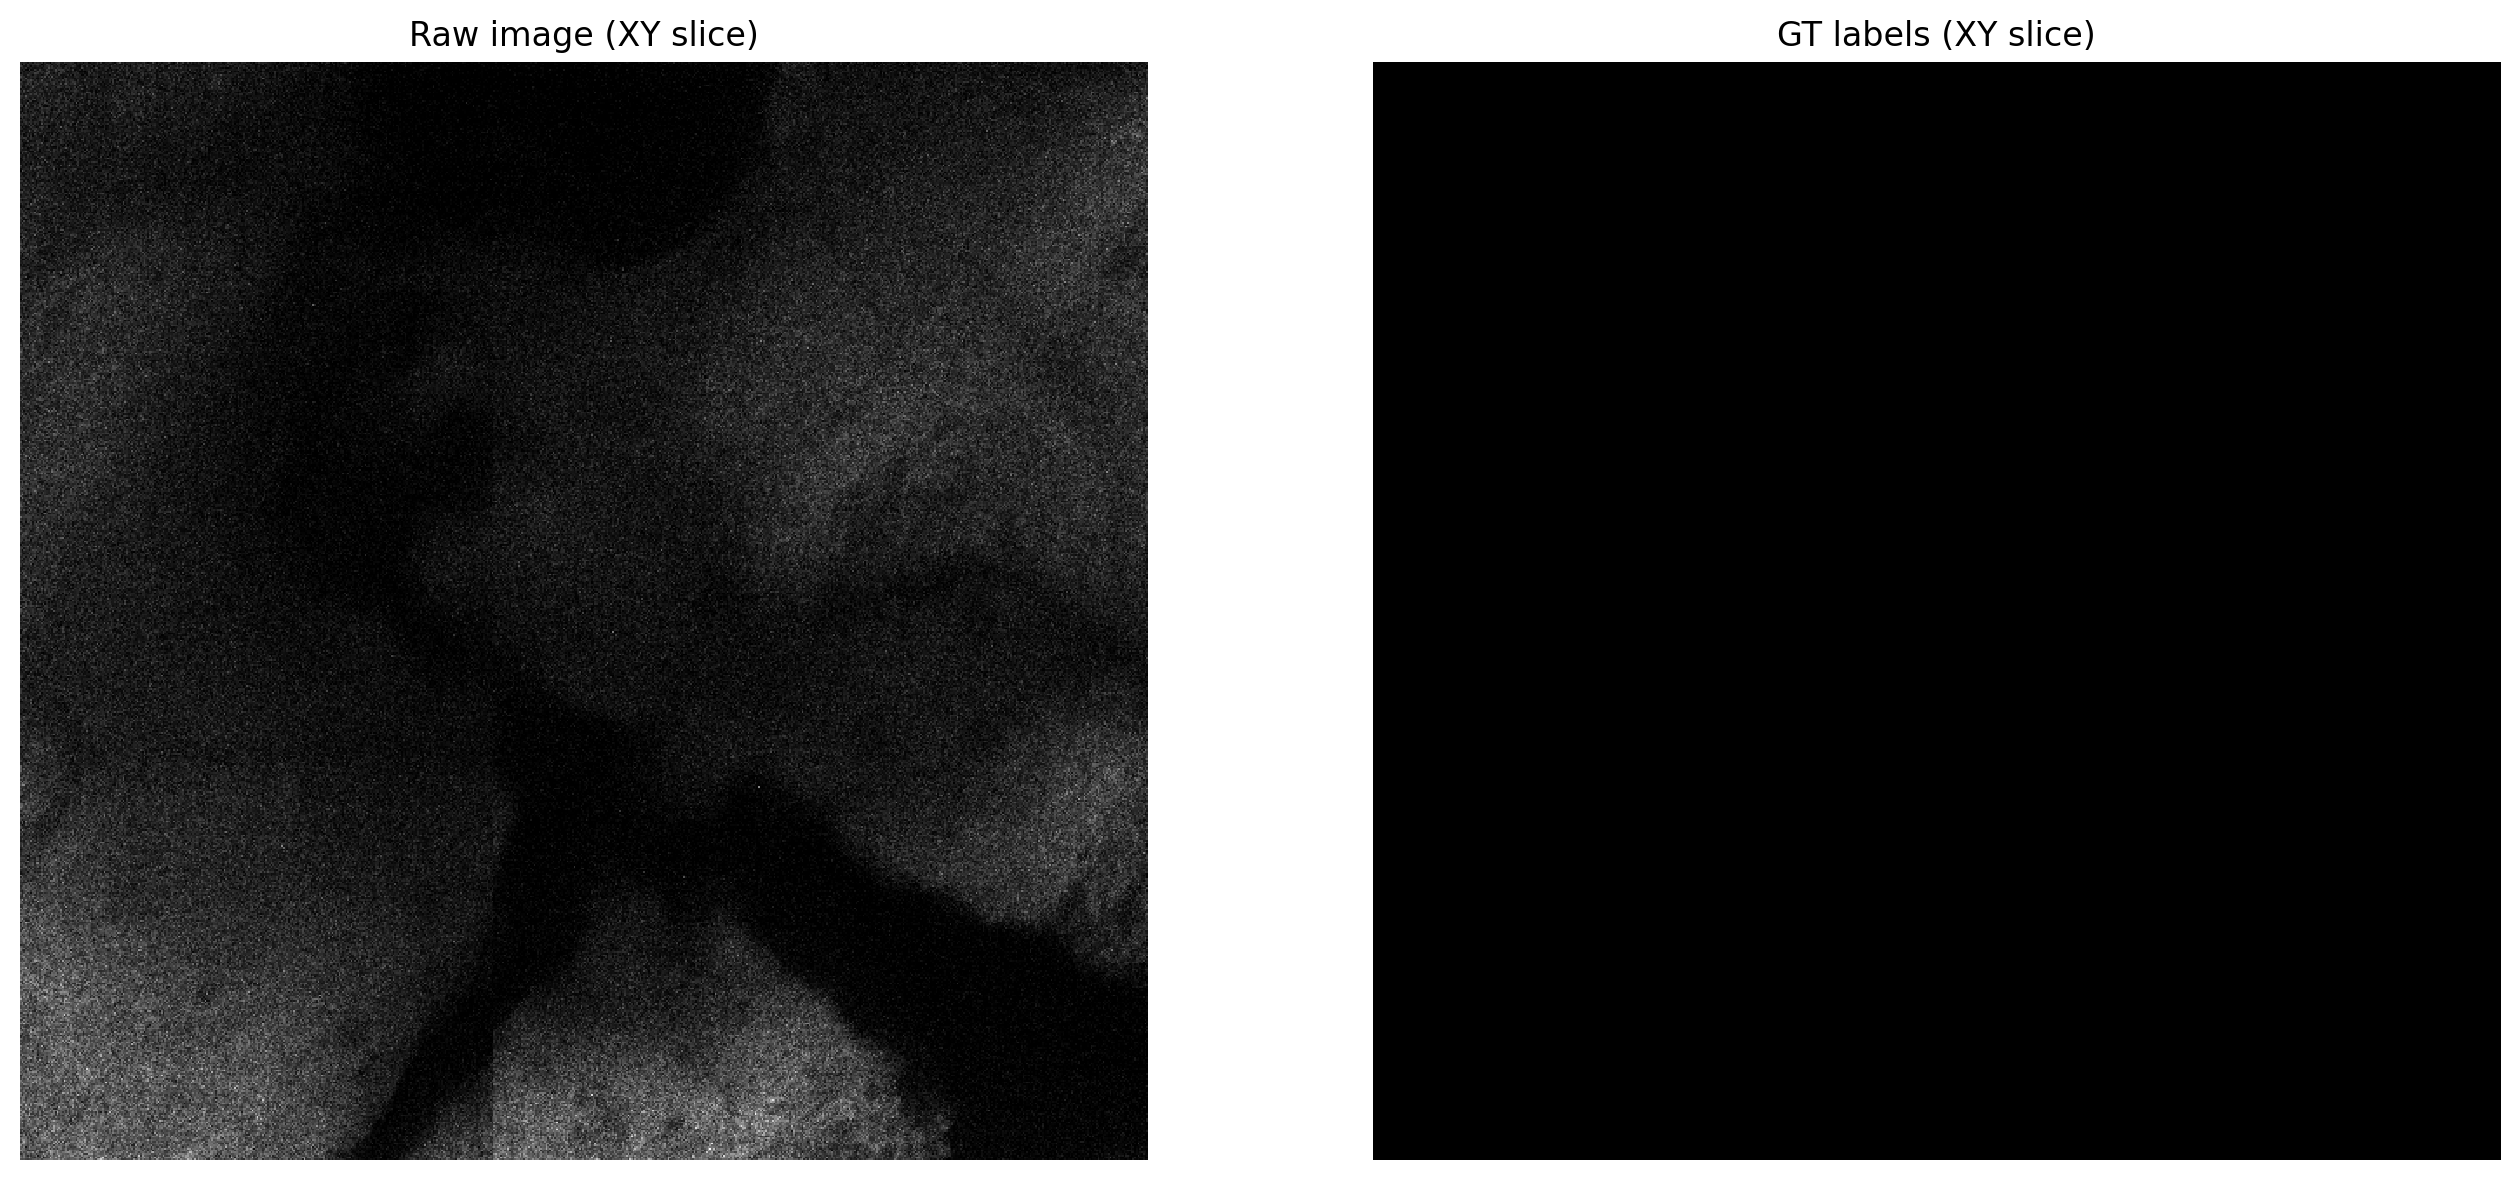

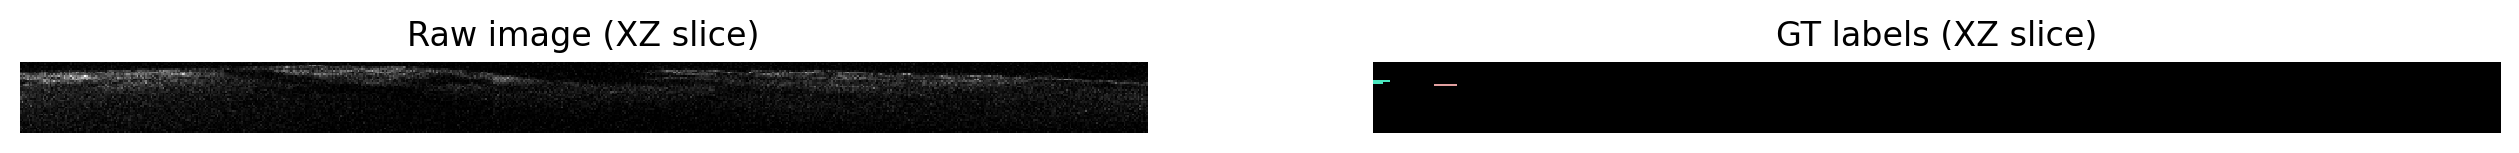

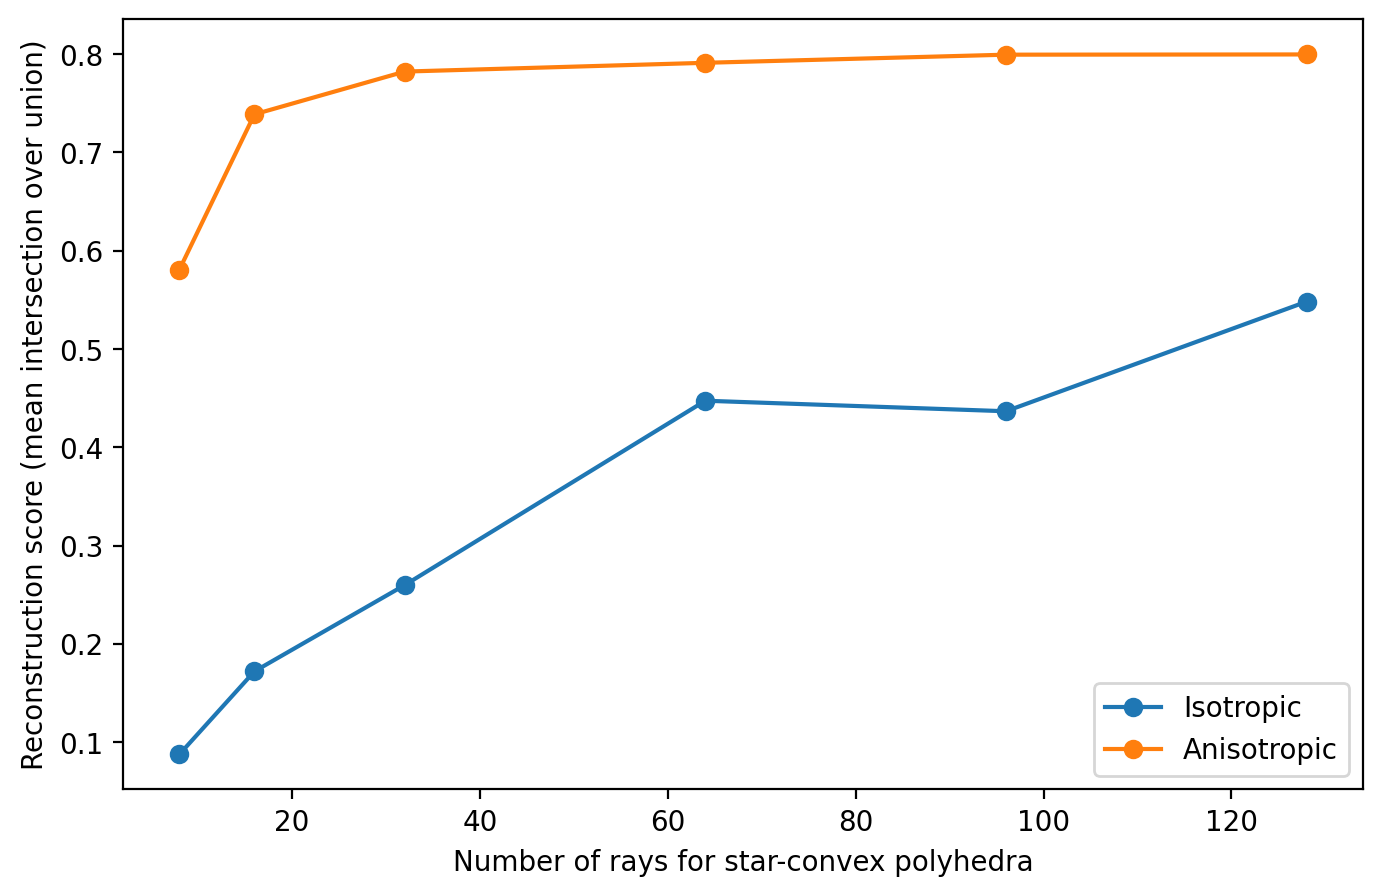

In [14]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;
plt.show()

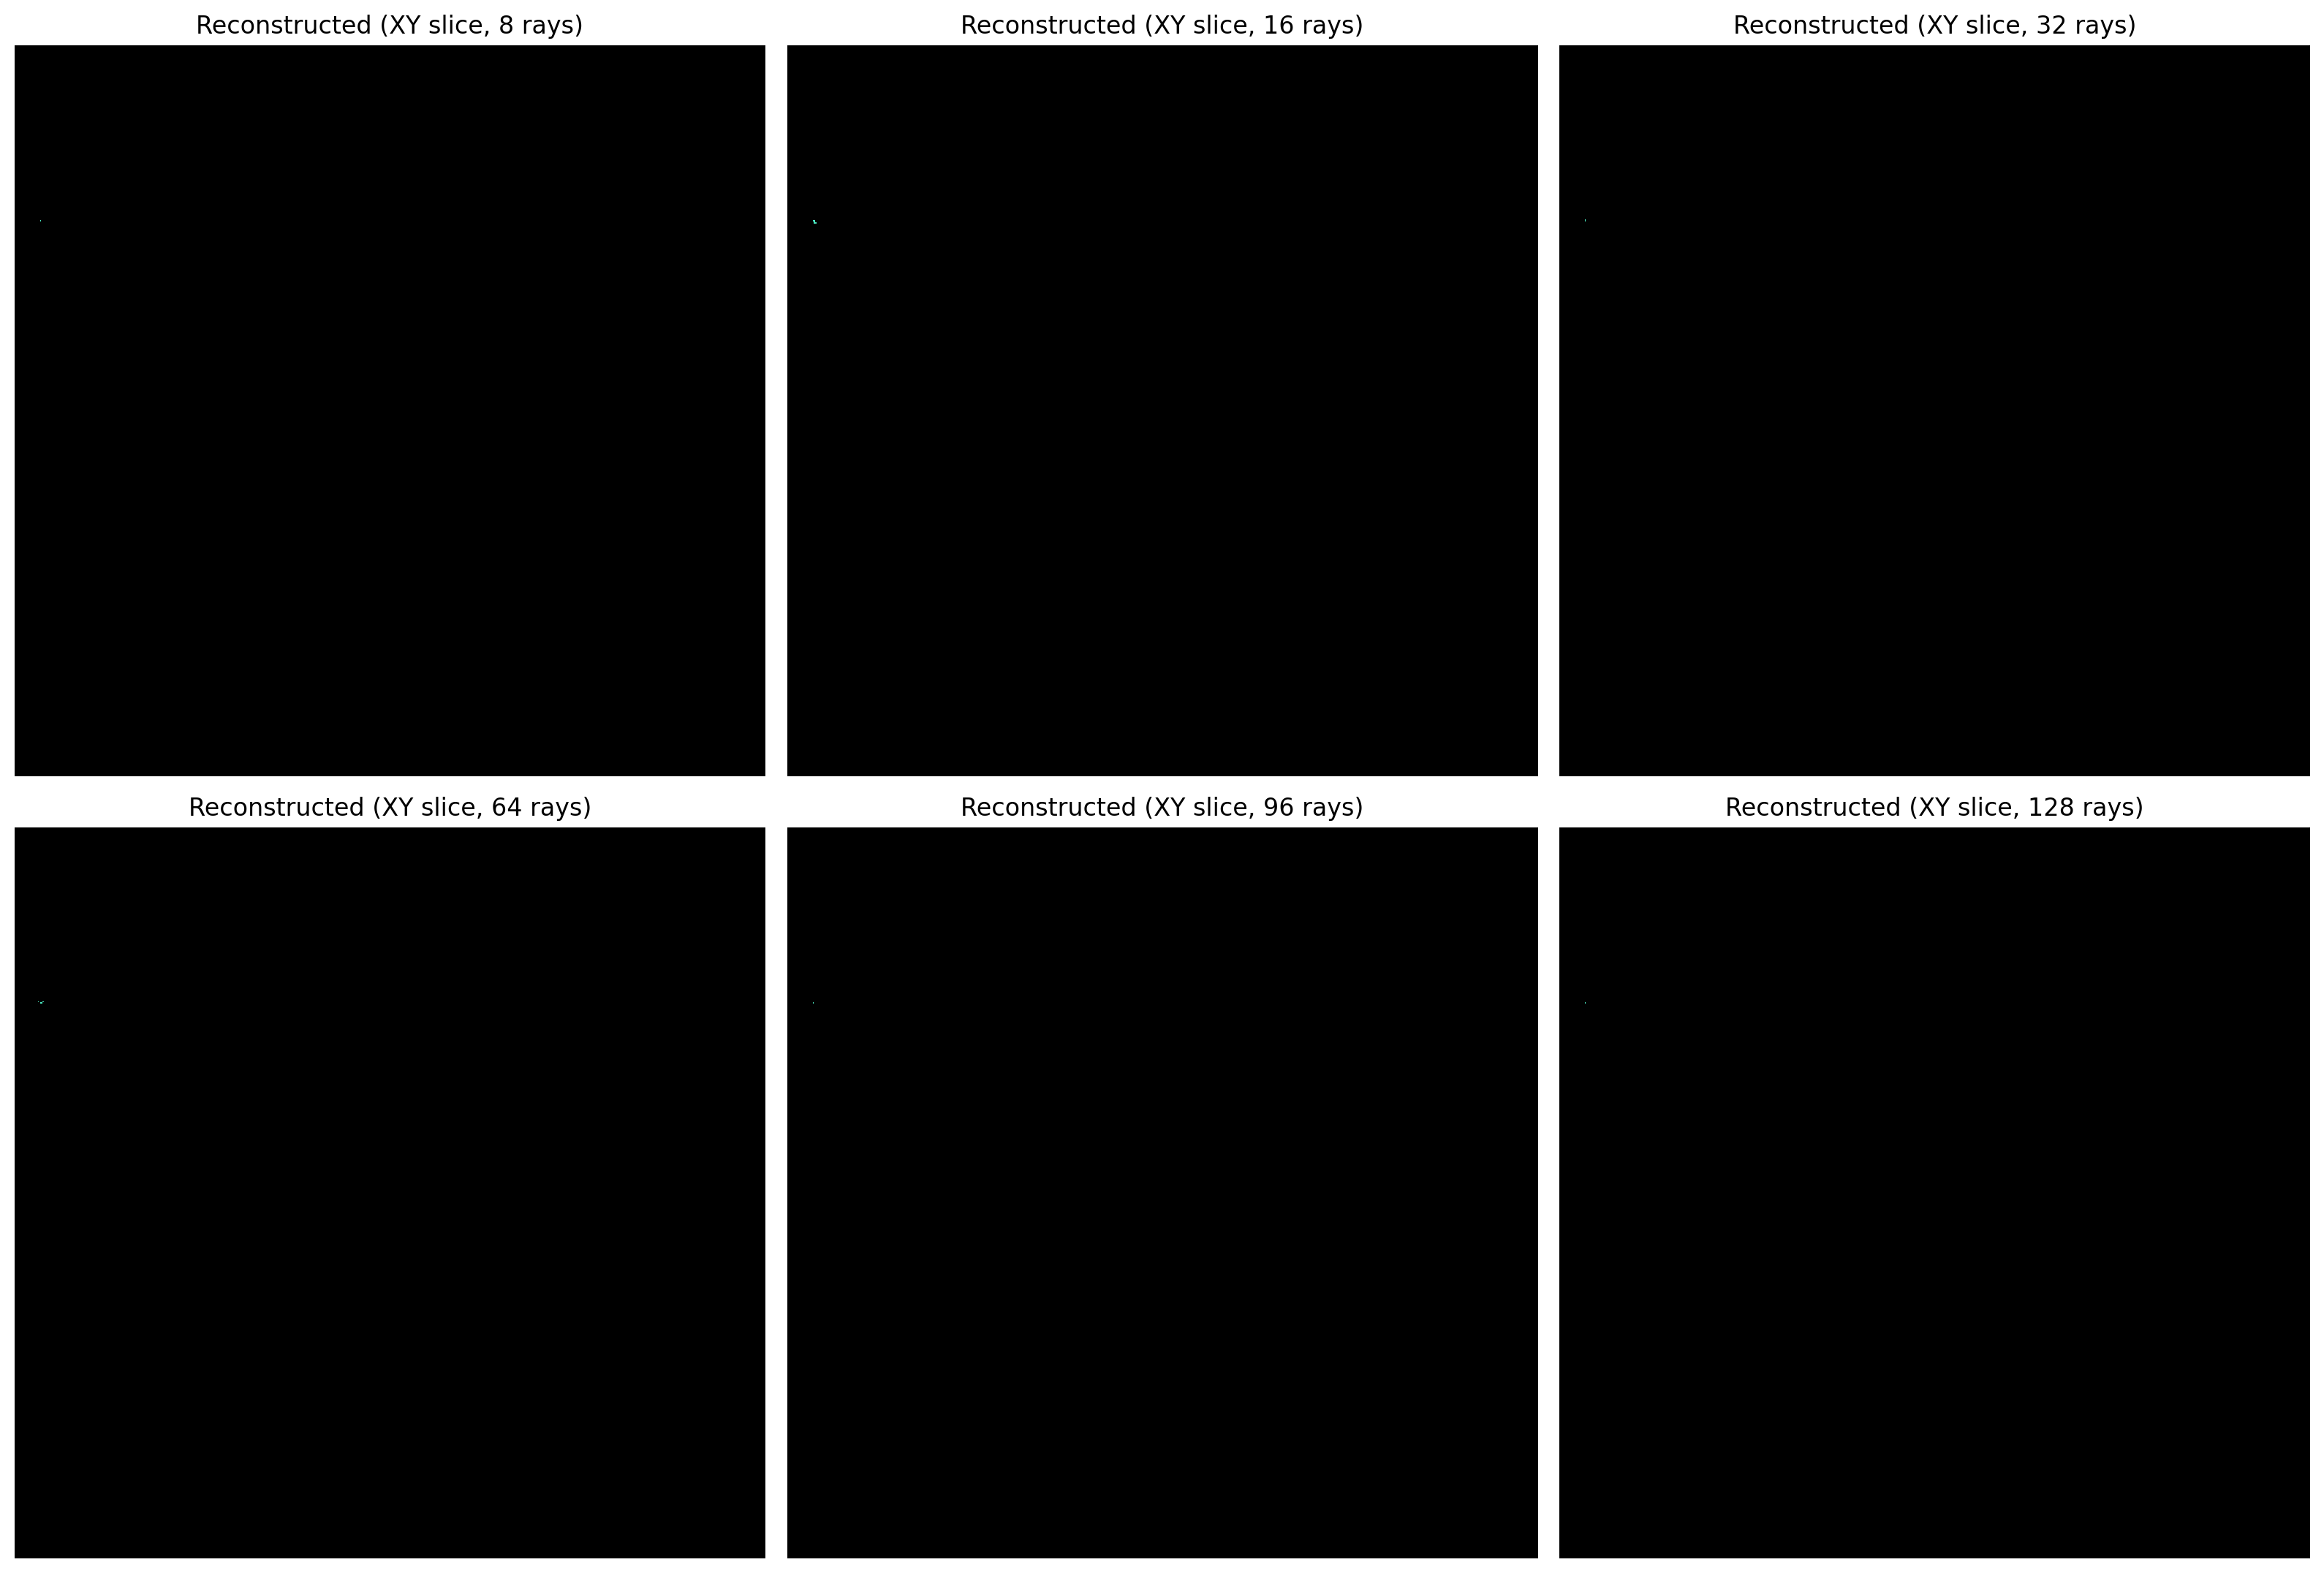

In [15]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=None)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();
plt.show()

In [2]:
##Training StarDist Model##
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
#Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, 
#where each image can have a different size. Alternatively, a single numpy array can also be used if all images have 
#the same size. Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) 
#arrays, where the channel axis comes last. Label images need to be integer-valued.


In [3]:
X = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Training_Patches_3D_SplitScript/Images/*.tif'))
Y = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Training_Patches_3D_SplitScript/Masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

In [5]:
Y_labels = []
for img in Y:
    array = np.array(img)
    array = (array * 255).astype(np.uint8)
    Y_labels.append(array)

In [6]:
X_squeezed = [np.squeeze(x) for x in X]
Y_squeezed = [np.squeeze(y) for y in Y_labels]

In [7]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_squeezed)]
Y = [fill_label_holes(y) for y in tqdm(Y_squeezed)]

100%|███████████████████████████████████████████████████████████████████████████| 140/140 [00:05<00:00, 24.12it/s]


In [8]:
import tensorflow as tf

In [9]:
tf.shape(Y[1])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 41, 478, 648])>

In [10]:
 #Training data consists of pairs of input image and label instances
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 140
- training:       119
- validation:      21


In [34]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    plt.show()

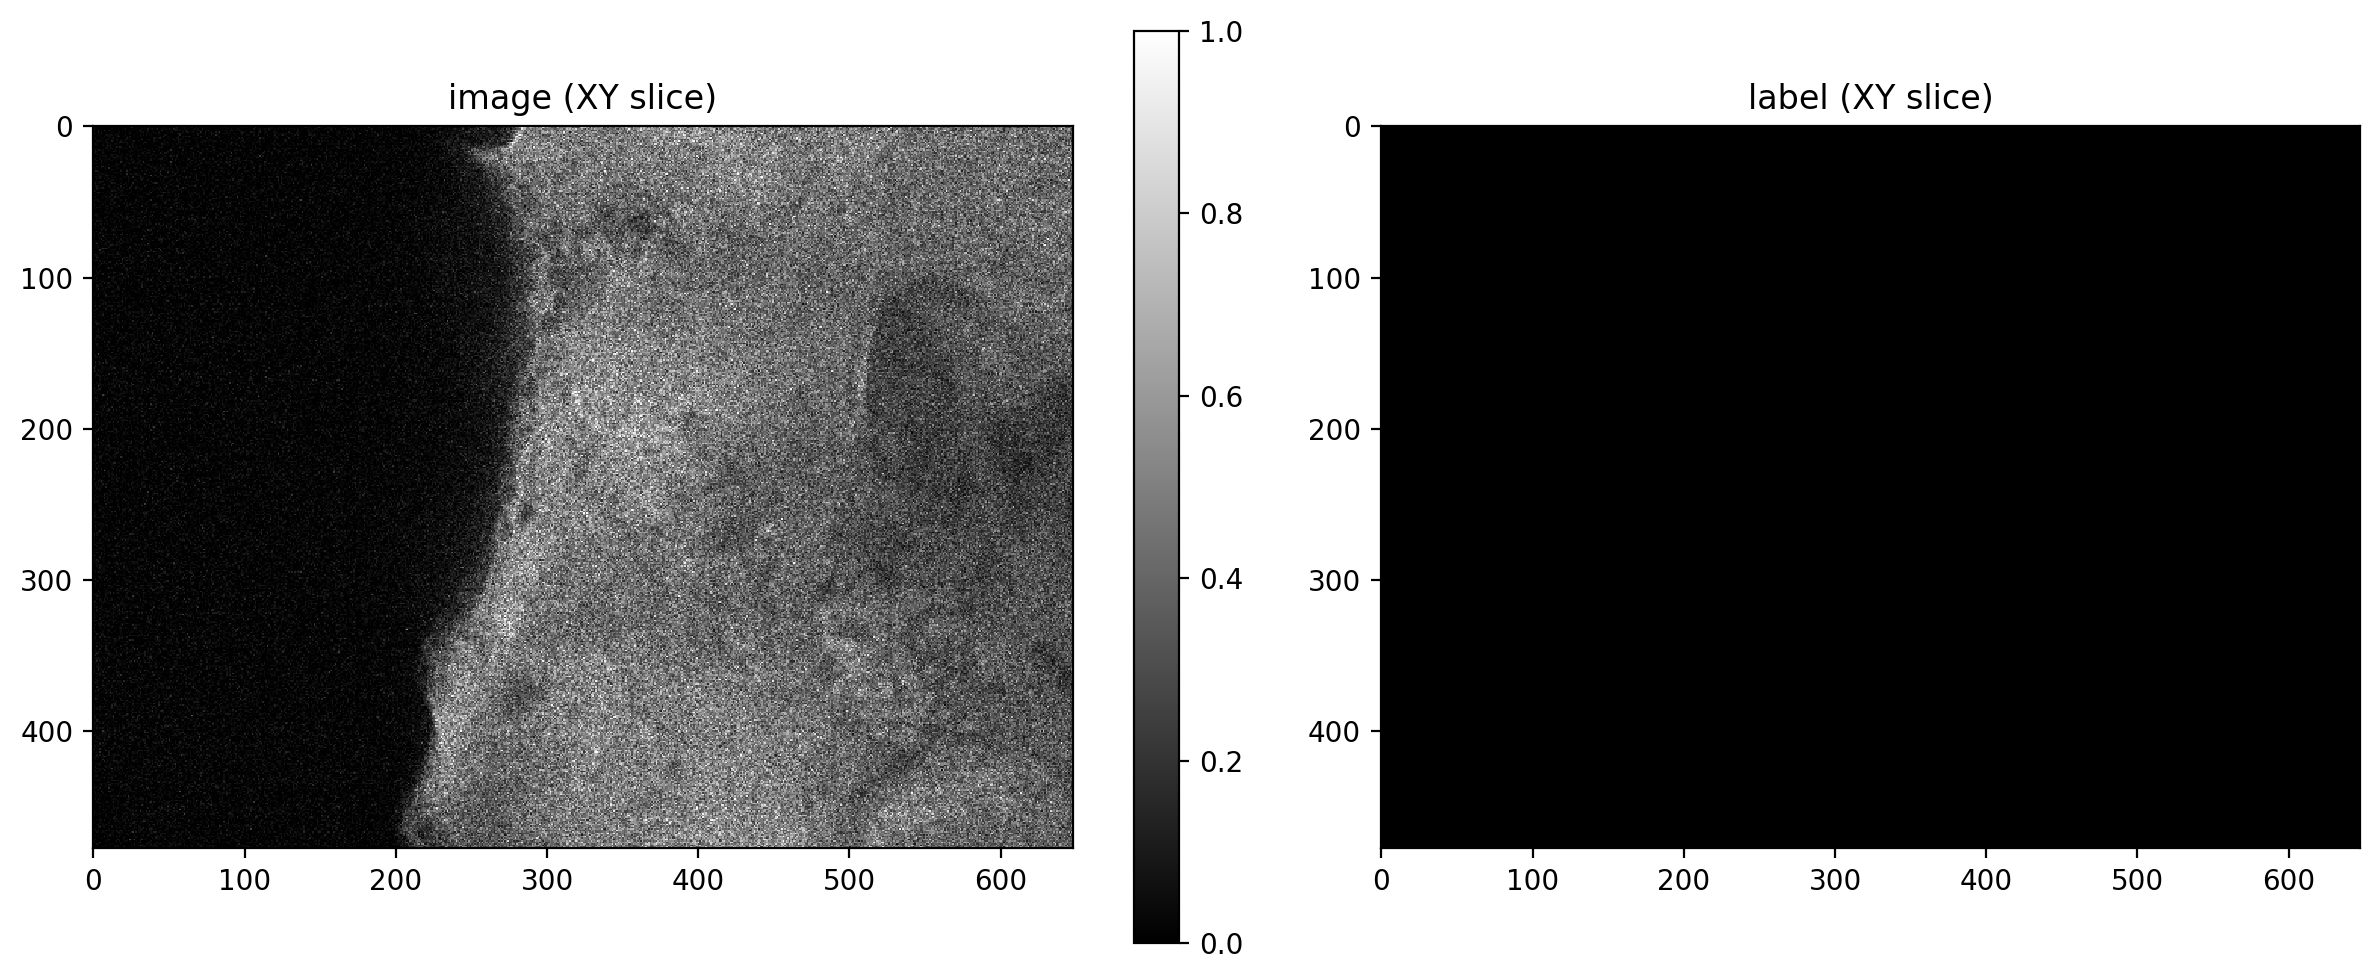

In [36]:
i = 66
img, lbl = X[i], Y_labels[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

In [ ]:
#A StarDist3D model is specified via a Config3D object.
print(Config3D.__doc__)

In [11]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (16.0, 1.0, 1.0847457627118644)


In [ ]:
256%8

In [12]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 16

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible, FIRST DIMENSION MUST BE DIVISIBLE BY 4, X and Y muct be divisible by 8)
    train_patch_size = (32,192,192),
    train_batch_size = 2,
    train_epochs = 400,
    train_steps_per_epoch = 100,
    unet_n_depth = 2,
)
#print(conf)
vars(conf)

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 17,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 16,
 'grid': (1, 2, 2),
 'anisotropy': (16.0, 1.0, 1.0847457627118644),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 16, 'anisotropy': (16.0, 1.0, 1.0847457627118644)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (32, 192, 192),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1

In [13]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [14]:
#Note: The trained StarDist3D model will not predict completed shapes for partially visible objects at the image boundary.
model = StarDist3D(conf, name='3Dstardist_400epoch_100steps_SplitScript_16Rays', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [15]:
#Check if the neural network has a large enough field of view to see up to the boundary of most objects.
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 64, 128, 128, 1))


median object size:      [ 1.   16.   14.75]
network field of view :  [26 46 46]


In [16]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y

In [ ]:
# plot some augmented examples
img, lbl = X[2],Y[2]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

Epoch 1/400


In [ ]:
model.optimize_thresholds(X_val, Y_val)

In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

In [ ]:
import napari

In [ ]:
viewer = napari.view_image(X_val[0], name= 'Val.Image', scale = [3.0,0.208,0.208])
viewer.add_image(Y_val[0], name='GT_Labels', scale = [3.0,0.208,0.208])
viewer.add_image(Y_val_pred[0], name= 'Predicted_Labels', scale = [3.0,0.208,0.208])

In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

In [ ]:
#Choose several IoU thresholds that might be of interest and for each compute matching statistics for the validation data.
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

In [ ]:
stats[taus.index(0.7)]

In [ ]:
#Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
plt.show()

In [ ]:
#Prediction

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
import skimage as sk
import napari
import pandas as pd
import os
from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [ ]:
files = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/training_images/*.tif'))
imgs = list(map(imread,files))
names = os.listdir('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/training_images/')
path = 'E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Predictions/'
#print(files[0][:-4])
# viewer = napari.view_image(imgs[0], name= 'test')

In [ ]:
imgs[0].shape

In [ ]:
model = StarDist3D(None, name='stardist', basedir='models')

In [ ]:
for i in range(len(imgs)):
    n_channel = 1 if imgs[i].ndim == 3 else imgs[i].shape[-1]
    axis_norm = (0,1,2)   # normalize channels independently
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    img = normalize(imgs[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img, n_tiles=model._guess_n_tiles(img), show_tile_progress=False)
    save_tiff_imagej_compatible(path+names[i][:-4]+"_labels.tif", labels, axes='ZYX')
    print(str(i)+" of "+str(len(imgs))+" complete")


In [ ]:
import napari

In [ ]:
files_labels = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/training_images_labels/*.tif'))
labels = list(map(imread,files_labels))
files_predictions = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Predictions/*.tif'))
predictions = list(map(imread,files_predictions))

In [ ]:
viewer = napari.view_image(imgs[1], name= 'Image')
viewer.add_image(labels[1], name='GT_Labels')
viewer.add_image(predictions[1], name= 'Predicted_Labels')